# futureEXPERT usage reference

## Getting started

This section shows the most simple approach to create forecasts of your time series in Python.
If you want to review interim results, have a look at the stepwise execution in the advanced examples.


### Login and expert client
futureEXPERT needs credentials for authentication. In order to log in, you create an authenticated client which handles all interactions with the future platform.

If you do not have an account for future yet, you can apply for a trial account [here](https://www.prognostica.de/de/future.html).

Additionally, if you are not subscribed for futureEXPERT, please contact us at support@future.prognostica.de

In [9]:
from futureexpert import ExpertClient

# You can provide your credentials from an .env file (see .env.example)
import dotenv
dotenv.load_dotenv()

# Log in using your credentials or alternatively provide FUTURE_USER and FUTURE_PW via environment variables or .env file
client = ExpertClient(user='', password='')

INFO:futureexpert.expert_client:Successfully logged in for group customer2.


### Your Data

futureEXPERT offers you various forecasting options to handle your individual forecasting use case with your data. In this example, we use a csv file but you could also use a pandas data frame.

### Data specific configurations and forecasting configuration

The configuration of a forecasting report is devided into three main sections:

* data definition and time series creation (via frontend or code)
  
  The prefered way to configure data defintion is by using the future frontend https://future.prognostica.de as it provides the full range of available features, e.g. rules for handling detected data issues, inclusion & exlusion rules for data preparation. More details and an example can be found in the section [Use the check-in configuration file from future frontend](#Use-the-check-in-configuration-file-from-future-frontend).
* forecasting report (via code)


In [10]:
from futureexpert import *

# In any case, configure the forecasting report in code
fc_report_config = ReportConfig(title='My first report',
                                forecasting=ForecastingConfig(fc_horizon=7,
                                                              lower_bound=0,
                                                              confidence_level=0.8),
                                preprocessing=PreprocessingConfig(use_season_detection=True,
                                                                  detect_outliers=True,
                                                                  replace_outliers=True))

### Alternative 1: Use the check-in configuration file from future frontend

Use a check-in configuration file from the future frontend https://future.prognostica.de:

1. Upload your data using Python or future frontend.
2. Navigate to 'My Data' in future frontend.
3. Start the check-in process from a file.
4. Follow along the check-in steps in the frontend.
5. Download the configuration at the end.

You can then reuse your uploaded data with the downloaded check-in configuration for forecasting in futureEXPERT or even reuse the check-in configuration for new data.

### Alternative 2: Configure everything in code

Define data definition and time series creation in code:

In [11]:
from futureexpert import *

data_definition = DataDefinition(
    date_columns=DateColumn(name='Date', format='%Y-%m-%d'),
    value_columns=[ValueColumn(name='value')],
    group_columns=[GroupColumn(name='Name')])

ts_creation_config = TsCreationConfig(timeGranularity='daily',
                                      grouppinglevel=['Name'],
                                      valueColumnsToSave=['value'],
                                      missingValueHandler='setToZero')

### Invoke forecast computation

Computation of the forecasting results takes some time depending on the number of time series and the configurations you choose. Therefor, the computation of the results is an asynchoronous operation which does not block your Python environment. Let's watch the status of the forecast computation before accessing the results.

In [12]:
# Alternative 1: Use the check-in configuration file from future frontend for full functionality
# Request forecast creation and retrieve the id for status requests and result retrieval
forecast_identifier = client.create_forecast_from_raw_data(raw_data_source='../example-data/bicycle_data.csv',
                                                           config_fc=fc_report_config,
                                                           config_from_json='../example-data/config_bicycle_data.json')

INFO:futureexpert.expert_client:Transforming input data...
INFO:futureexpert.expert_client:Creating time series using futureCHECK-IN...


INFO:futureexpert.expert_client:Finished time series creation.
INFO:futureexpert.expert_client:Preparing data for forecast...
INFO:futureexpert.expert_client:Finished data preparation for forecast.
INFO:futureexpert.expert_client:Started creating forecasting report with futureFORECAST...
INFO:futureexpert.expert_client:Finished report creation. Forecasts are running...


In [13]:
# Alternative 2: Configure everything in code
# Request forecast creation and retrieve the id for status requests and result retrieval
forecast_identifier2 = client.create_forecast_from_raw_data(raw_data_source='../example-data/bicycle_data.csv',
                                                            data_definition=data_definition,
                                                            config_ts_creation=ts_creation_config,
                                                            config_fc=fc_report_config,
                                                            file_specification=FileSpecification(delimiter=';', decimal='.'))

INFO:futureexpert.expert_client:Started data definition using futureCHECK-IN...
INFO:futureexpert.expert_client:Finished data definition.
INFO:futureexpert.expert_client:Transforming input data...
INFO:futureexpert.expert_client:Creating time series using futureCHECK-IN...
INFO:futureexpert.expert_client:Finished time series creation.
INFO:futureexpert.expert_client:Preparing data for forecast...
INFO:futureexpert.expert_client:Finished data preparation for forecast.
INFO:futureexpert.expert_client:Started creating forecasting report with futureFORECAST...
INFO:futureexpert.expert_client:Finished report creation. Forecasts are running...


In [14]:
import time

# Watch the current status of the forecasting report
while not (current_status := client.get_forecast_status(id=forecast_identifier)).is_finished:
    current_status.print()
    print('Waiting another 30 seconds to finish forecasting...')
    time.sleep(30)  # Wait between status requests

current_status.print()

# Retrieve the final results
results = client.get_fc_results(id=forecast_identifier, include_forecasts=True, include_backtesting=True, include_preprocessing=True)

Status forecasting report for id: report_id=205 settings_id=205
 0 % are finished 
 3 time series requested for calculation 
 0 time series are finished 
 0 time series are no evaluation 
 0 time series calculation run into an error
Waiting another 30 seconds to finish forecasting...
Status forecasting report for id: report_id=205 settings_id=205
 67 % are finished 
 3 time series requested for calculation 
 2 time series are finished 
 0 time series are no evaluation 
 0 time series calculation run into an error
Waiting another 30 seconds to finish forecasting...
Status forecasting report for id: report_id=205 settings_id=205
 100 % are finished 
 3 time series requested for calculation 
 3 time series are finished 
 0 time series are no evaluation 
 0 time series calculation run into an error


### Visualize results

The expert client offers plotting functionality of the forecasts including its prediction intervals (if available) and of the backtesting iterations.

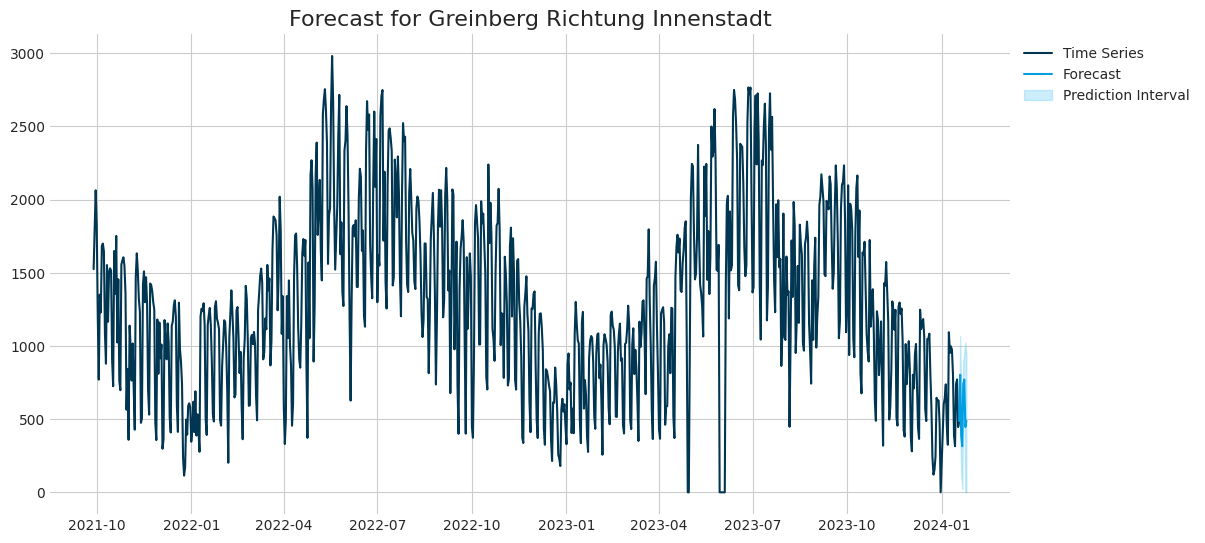

In [15]:
from futureexpert import plot

forecasts = results['forecasts'][0]
plot.plot_forecast(forecasts)

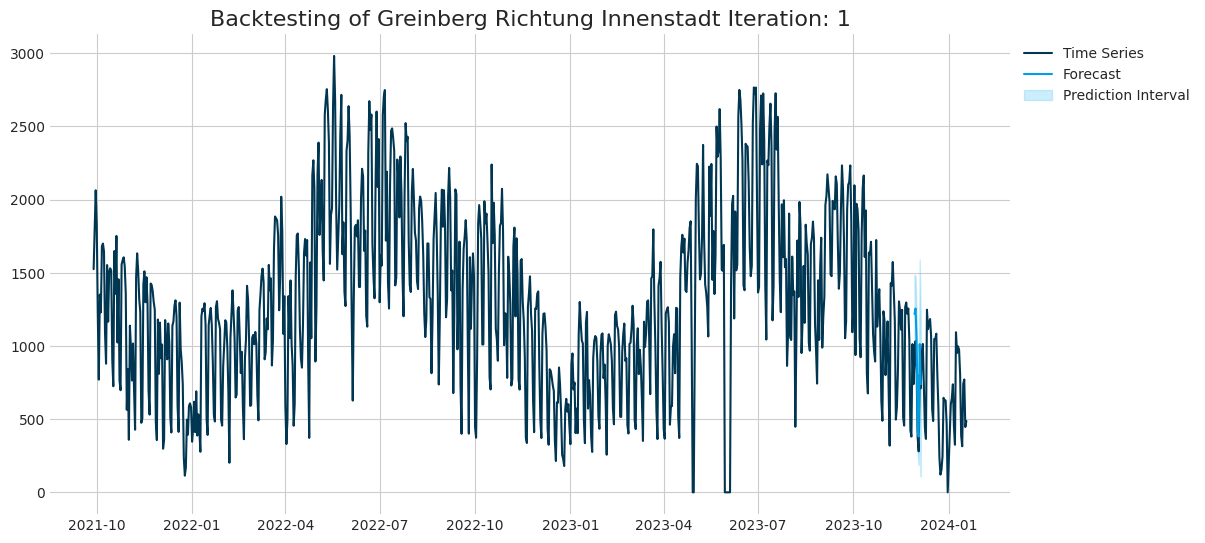

In [16]:
from futureexpert import plot

forecasts = results['forecasts'][0]
plot.plot_backtesting(forecasts, iteration=1)